## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

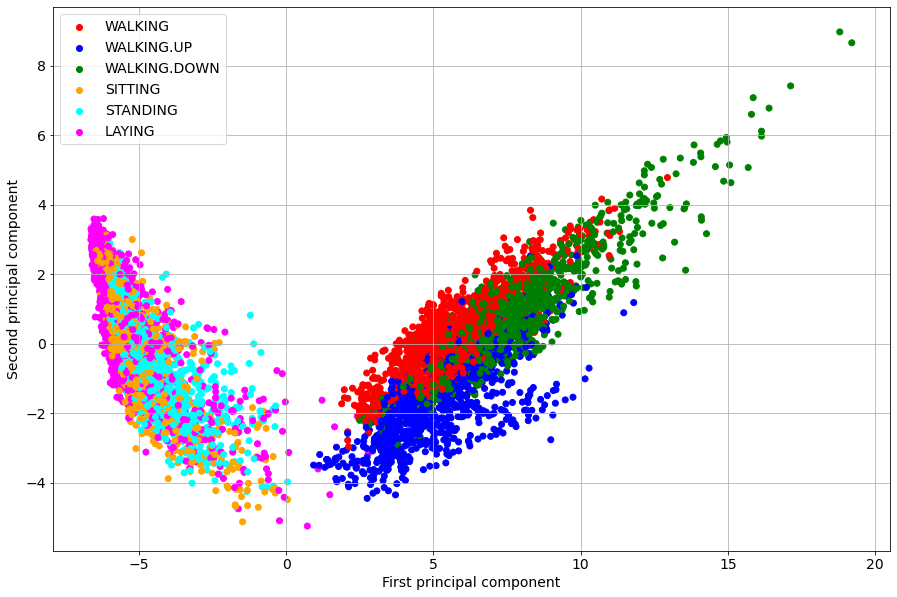

In [4]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [5]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [6]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [7]:
# Your experiments here
import torch
from torch import nn

In [8]:
import time

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_train_accuracy = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()

            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()

            opt.step()
            ep_train_loss.append(loss.item())

            _, y_pred = torch.max(outputs, 1)
            ep_train_accuracy.append(torch.sum(y_pred == y_batch.data) / len(y_batch))

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                # compute predictions
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                ep_val_loss.append(loss)

                _, y_pred = torch.max(outputs, 1)
                ep_val_accuracy.append(torch.sum(y_pred == y_batch.data) / len(y_batch))

        # print the results for this epoch:
        # print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        # print(f"\t  training loss: {train_loss[-1]:.6f}")
        # print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        # print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, train_accuracy, val_loss, val_accuracy

In [9]:
def show_result(train_loss, train_accuracy, val_loss, val_accuracy):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='validation')
    plt.xlabel('n_epoch')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='train')
    plt.plot(val_accuracy, label='validation')
    plt.xlabel('n_epoch')
    plt.legend()
    plt.title('Accuracy')

    print('Validation accuracy = {:.3f}'.format(val_accuracy[-1]))

#### Шаг 0. Предобработаем данные

In [10]:
from torch.utils.data import TensorDataset, DataLoader

y_train_tensor = torch.squeeze(torch.LongTensor(y_train), axis=1)
y_test_tensor = torch.squeeze(torch.LongTensor(y_test), axis=1)

train_dataset = TensorDataset(torch.tensor(X_train).transpose(1, 2), y_train_tensor)
test_dataset = TensorDataset(torch.tensor(X_test).transpose(1, 2), y_test_tensor)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=256)

l = [l for l in train_loader]
l[0][0].shape, torch.tensor(X_train).transpose(1, 2).shape

(torch.Size([256, 9, 128]), torch.Size([7352, 9, 128]))

#### Шаг 1. Линейная сеть с двумя слоями
Напишем простую сеть с двумя линейными слоями. Промежуточное число нейронов подберем из диапазона 300 -- 30.
В качестве слоя активации используем ReLU, последний слой -- LogSoftMax.

In [11]:
import time

In [172]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_input * n_steps, 100),
    nn.ReLU(),
    nn.Linear(100, n_classes),
    nn.LogSoftmax()
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

UsageError: Line magic function `%%time` not found.


In [173]:
%%time
res = train_model(model, train_loader, test_loader, criterion, optimizer, n_epochs=30)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 5.68 s, sys: 253 ms, total: 5.93 s
Wall time: 6.71 s


Validation accuracy = 0.879


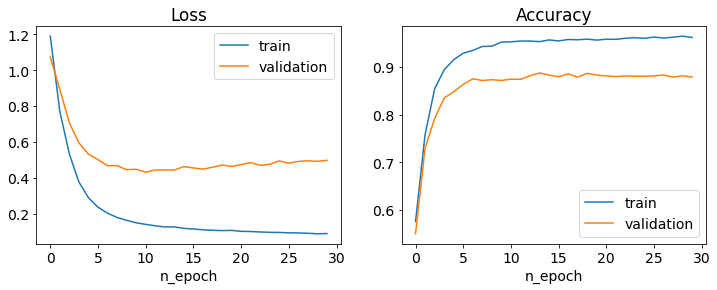

In [174]:
show_result(*res)

**Ура! Мы достигли отметки точности в 0.86!**

#### Шаг 1.1. Линейная сеть с двумя слоями
Напишем простую сеть с двумя линейными слоями. Промежуточное число нейронов подберем из диапазона 300 -- 30.
В качестве слоя активации используем ReLU, последний слой -- LogSoftMax.

In [175]:
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_input * n_steps, 300),
    nn.ReLU(),
    nn.Linear(300, n_classes),
    nn.LogSoftmax()
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

In [176]:
%%time
res1 = train_model(model1, train_loader, test_loader, criterion, optimizer, n_epochs=30)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 9.09 s, sys: 330 ms, total: 9.42 s
Wall time: 11 s


Validation accuracy = 0.890


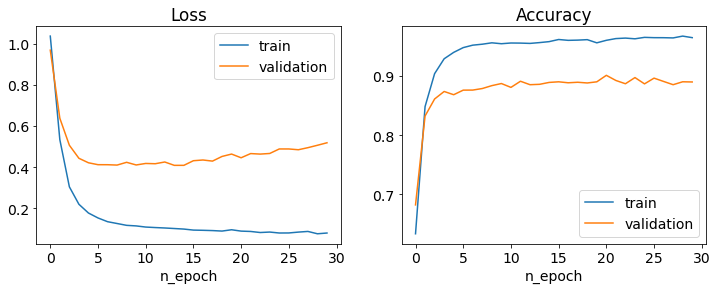

In [177]:
show_result(*res1)

**Ура! Мы достигли отметки точности в 0.89!** Однако Loss начал расти

#### Шаг 2. Линейная сеть с тремя слоями
Слои активации такие же. Выходной слой тоже. Добавим третий линейный слой. Число нейронов будет, соответственно 300, 100

In [184]:
model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_input * n_steps, 200),
    nn.ReLU(),
    nn.Linear(200, 30),
    nn.ReLU(),
    nn.Linear(30, n_classes),
    nn.LogSoftmax()
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [185]:
%%time
res2 = train_model(model2, train_loader, test_loader, criterion, optimizer, n_epochs=30)

CPU times: user 7.02 s, sys: 271 ms, total: 7.29 s
Wall time: 7.25 s


Validation accuracy = 0.863


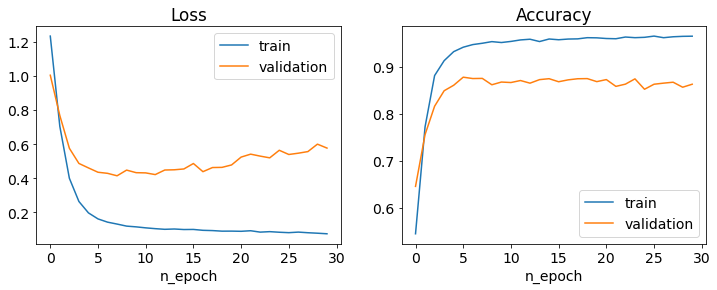

In [186]:
show_result(*res2)

**Точность немного упала, а Loss всё еще растет. Попробуем добавить BatchNormalization, DropOut**

#### Шаг 2.1. Линейная сеть с тремя слоями и DropOut
Добавим DropOut между 2 и 3 линейными слоями.

In [197]:
model3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_input * n_steps, 200),
    nn.ReLU(),
    nn.Linear(200, 30),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(30, n_classes),
    nn.LogSoftmax()
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-3)

In [198]:
%%time
res3 = train_model(model3, train_loader, test_loader, criterion, optimizer, n_epochs=30)

CPU times: user 7.79 s, sys: 350 ms, total: 8.14 s
Wall time: 9.62 s


Validation accuracy = 0.888


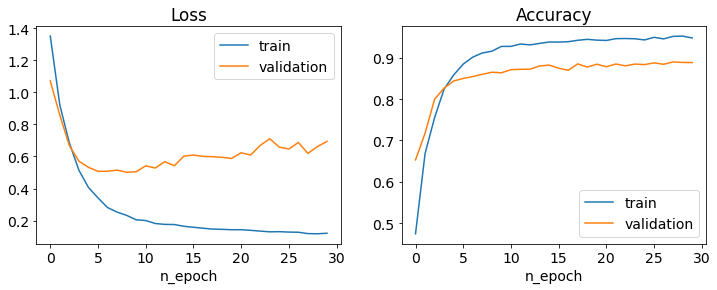

In [199]:
show_result(*res3)

#### Шаг 2.2. Линейная сеть с тремя слоями и DropOut и BatchNormalization
Добавим BatchNormalization между 1 и 2 линейными слоями.

Здесь было скрыто несколько итераций, в ходе которых мы подобрали лучшие знаяения для числа нейронов -- 300 и 50, соответственно.

In [20]:
model4 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_input * n_steps, 300),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300, 50),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(50, n_classes),
    nn.LogSoftmax()
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=1e-3)

In [21]:
%%time
res4 = train_model(model4, train_loader, test_loader, criterion, optimizer, n_epochs=30)

CPU times: user 9.51 s, sys: 425 ms, total: 9.93 s
Wall time: 9.99 s


Validation accuracy = 0.911


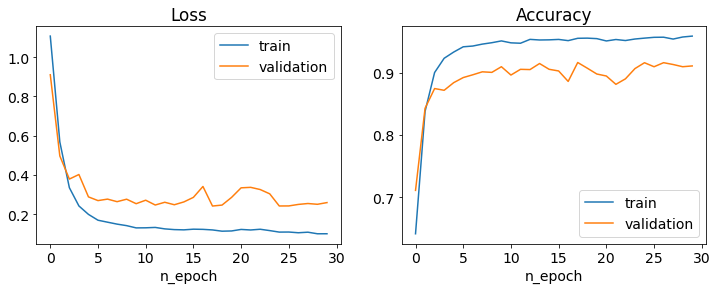

In [22]:
show_result(*res4)

**Ура! Мы достигли отметки точности в 0.91! Это победа и 3 балла за лабу :)**

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
# Your experiments here